In [1]:
from pulse2percept.models import AxonMapModel, BiphasicAxonMapModel, BiphasicAxonMapSpatial, Model, AxonMapSpatial
from pulse2percept.stimuli import Stimulus, BiphasicPulseTrain
from pulse2percept.implants import DiskElectrode, ProsthesisSystem, ArgusII, ElectrodeArray

import os
# os.environ['JAX_PLATFORM_NAME']="cpu" # uncomment to force cpu
# os.environ['CUDA_VISIBLE_DEVICES']='1' # 3060

# import numpy as np
import jax.numpy as np
import jax
from jax import jit
jax.devices()

[GpuDevice(id=0, process_index=0), GpuDevice(id=1, process_index=0)]

## Where the magic happens (Jax predict_percept())

In [10]:
"""
Function to be JIT'ed. (Eventually)
Must be purely functional, and follow all rules at https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html

"""
def gpu_biphasic_axon_map(amps, freqs, pdurs, x, y, # Per ACTIVE electrode
                          axon_segments, idx_start, idx_end, # ith segment goes from axon_segments[idx_start[i] : idx_end[i]]
                          rho, axlambda, thresh_percept, timesteps):
  deg2rad = 3.14159265358979323846 / 180.0
  n_space = len(idx_start)
  min_size = 10**2 / rho**2
  min_streak = 10**2 / axlambda **2

  # First get contributions from F, G, H per electrode
  scaled_amps = amps / (0.8825 + 0.27*pdurs)
  brights = 1.84*scaled_amps + 0.2*freqs + 2.0986
  sizes = np.maximum(1.081*scaled_amps - 0.3533764, min_size)
  streaks = np.maximum(1.56 - 0.54 * pdurs ** 0.21, min_streak)

#   I = np.zeros(shape=(n_space), dtype=np.float32)
  I = []

  for idx_space in range(n_space):
    # (n_segments, n_elecs)
    d2_el = ((axon_segments[idx_start[idx_space]:idx_end[idx_space], 0])[:, None] - x[None, :])**2. + ((axon_segments[idx_start[idx_space]:idx_end[idx_space], 1])[:, None] - y[None, :])**2. 

    # (n_segments, n_elecs)
    electrode_intensities = brights * np.exp(-d2_el / ( 2. * rho**2. * sizes)) * ((axon_segments[idx_start[idx_space]:idx_end[idx_space], 2])[:, None] ** (1. / streaks)[None, :])
    #                      (n_elec) * (n_segments, n_elecs)                  * (n_segments, n_elecs)

    # (n_segments)
    axon_intensities = np.sum(electrode_intensities, axis=1) # ith row is intensity at ith axon segment

    # axon_intensities = jax.ops.index_update(axon_intensities, (axon_intensities < thresh_percept), 0.0)

    I.append(np.max(axon_intensities))
#     I = jax.ops.index_update(I, idx_space, np.max(axon_intensities))
#     I[idx_space] = np.max(axon_intensities)

  return np.asarray(np.transpose(np.tile(np.array(I, dtype="float32"), (timesteps, 1))))


#### Build model here in new spatial subclass, wrapped in BiphasicAxonMapGPU

In [11]:
class BiphasicAxonMapGPUSpatial(AxonMapSpatial):
  def __init__(self, **params):
    super(BiphasicAxonMapGPUSpatial, self).__init__(**params)


  def _predict_spatial(self, earray, stim):
    assert isinstance(earray, ElectrodeArray)
    assert isinstance(stim, Stimulus)

    # get relevant stimulus properties
    amps = np.array([stim.metadata['electrodes'][str(e)]['metadata']['amp'] for e in stim.electrodes], dtype="float32")
    freqs = np.array([stim.metadata['electrodes'][str(e)]['metadata']['freq'] for e in stim.electrodes], dtype="float32")
    pdurs = np.array([stim.metadata['electrodes'][str(e)]['metadata']['phase_dur'] for e in stim.electrodes], dtype="float32")

    # make sure everything is JNP array not numpy
    return gpu_biphasic_axon_map(amps, freqs, pdurs,
                                 np.array([earray[e].x for e in stim.electrodes], dtype=np.float32),
                                 np.array([earray[e].y for e in stim.electrodes], dtype=np.float32),
                                 np.array(self.axon_contrib),
                                 np.array(self.axon_idx_start, dtype=np.uint32),
                                 np.array(self.axon_idx_end, dtype=np.uint32),
                                 self.rho, self.axlambda, self.thresh_percept, stim.shape[1])


class BiphasicAxonMapGPU(Model):
  def __init__(self, **params):
    super(BiphasicAxonMapGPU, self).__init__(spatial=BiphasicAxonMapGPUSpatial(), temporal=None, **params)

  def predict_percept(self, implant, t_percept=None):
    # Make sure stimulus is a BiphasicPulseTrain:
    if not isinstance(implant.stim, BiphasicPulseTrain):
      # Could still be a stimulus where each electrode has a biphasic pulse train
      for ele, params in implant.stim.metadata['electrodes'].items():
        if params['type'] != BiphasicPulseTrain or params['metadata']['delay_dur'] != 0: 
          raise TypeError("All stimuli must be BiphasicPulseTrains with no delay dur (Failing electrode: %s)" % (ele)) 
        
    return super(BiphasicAxonMapGPU, self).predict_percept(implant, t_percept=t_percept)


# Timing

In [12]:
model = BiphasicAxonMapGPU()
model.build()
implant = ArgusII()
stim = Stimulus({"A2" : BiphasicPulseTrain(20, 1, 0.45)})
implant.stim = stim

model_orig = BiphasicAxonMapModel()
model_orig.build()
print()

407 ms ± 7.62 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


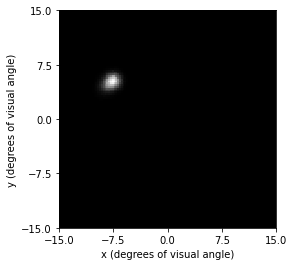

In [6]:
%%timeit 
###########
#  NUMPY  #
###########
# Run this cell for implemented predict_percept

percept = model.predict_percept(implant)
percept.plot()

3min 54s ± 3.51 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


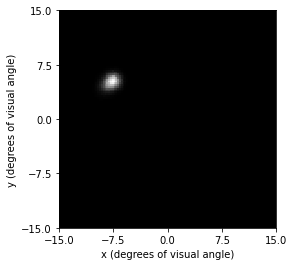

In [13]:
%%timeit 
###########
#   JAX   #
###########
## Run this cell for implemented predict_percept
percept = model.predict_percept(implant)
percept.plot()

9.22 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


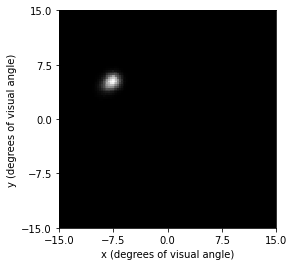

In [7]:
%%timeit 
###########
# ORIGINAL #
###########
## Run this cell for original biphasic predict_percept
p1 = model_orig.predict_percept(implant)
p1.plot()

In [8]:
#### Difference between implemented and original
p1 = model_orig.predict_percept(implant)
percept = model.predict_percept(implant)
np.max(percept.data - p1.data)

0.0

## NUMPY copy

In [ ]:
# numpy copy
"""
Function to be JIT'ed. 
Must be purely functional, and follow all rules at https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html

"""
def gpu_biphasic_axon_map(amps, freqs, pdurs, x, y, # Per ACTIVE electrode
                          axon_segments, idx_start, idx_end, # ith segment goes from axon_segments[idx_start[i] : idx_end[i]]
                          rho, axlambda, thresh_percept, timesteps):
  deg2rad = 3.14159265358979323846 / 180.0

  n_space = len(idx_start)

  min_size = 10**2 / rho**2
  min_streak = 10**2 / axlambda **2

  # First get contributions from F, G, H per electrode
  scaled_amps = amps / (0.8825 + 0.27*pdurs)
  brights = 1.84*scaled_amps + 0.2*freqs + 2.0986
  sizes = np.maximum(1.081*scaled_amps - 0.3533764, min_size)
  streaks = np.maximum(1.56 - 0.54 * pdurs ** 0.21, min_streak)

  I = np.zeros(shape=(n_space), dtype=np.float32)

  for idx_space in range(n_space):
    # (n_segments, n_elecs)
    d2_el = ((axon_segments[idx_start[idx_space]:idx_end[idx_space], 0])[:, None] - x[None, :])**2. + ((axon_segments[idx_start[idx_space]:idx_end[idx_space], 1])[:, None] - y[None, :])**2. 

    # (n_segments, n_elecs)
    electrode_intensities = brights * np.exp(-d2_el / ( 2. * rho**2. * sizes)) * ((axon_segments[idx_start[idx_space]:idx_end[idx_space], 2])[:, None] ** (1. / streaks)[None, :])
    #                      (n_elec) * (n_segments, n_elecs)                  * (n_segments, n_elecs)

    # (n_segments)
    axon_intensities = np.sum(electrode_intensities, axis=1) # ith row is intensity at ith axon segment

    # axon_intensities = jax.ops.index_update(axon_intensities, (axon_intensities < thresh_percept), 0.0)

#     I = jax.ops.index_update(I, idx_space, np.max(axon_intensities))
    I[idx_space] = np.max(axon_intensities)

  return np.asarray(np.transpose(np.tile(I, (timesteps, 1))))

## Another sandbox copy


In [ ]:
"""
Function to be JIT'ed. (Eventually)
Must be purely functional, and follow all rules at https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html

"""
def gpu_biphasic_axon_map(amps, freqs, pdurs, x, y, # Per ACTIVE electrode
                          axon_segments, idx_start, idx_end, # ith segment goes from axon_segments[idx_start[i] : idx_end[i]]
                          rho, axlambda, thresh_percept, timesteps):
    deg2rad = 3.14159265358979323846 / 180.0
    n_space = len(idx_start)
    min_size = 10**2 / rho**2
    min_streak = 10**2 / axlambda **2

    # First get contributions from F, G, H per electrode
    scaled_amps = amps / (0.8825 + 0.27*pdurs)
    brights = 1.84*scaled_amps + 0.2*freqs + 2.0986
    sizes = np.maximum(1.081*scaled_amps - 0.3533764, min_size)
    streaks = np.maximum(1.56 - 0.54 * pdurs ** 0.21, min_streak)
    #   I = np.zeros(shape=(n_space), dtype=np.float32)
    I = []

    starts = idx_start[]
    

    
    
    
    
    for idx_space in range(n_space):
        # (n_segments, n_elecs)
        d2_el = ((axon_segments[idx_start[idx_space]:idx_end[idx_space], 0])[:, None] - x[None, :])**2. + ((axon_segments[idx_start[idx_space]:idx_end[idx_space], 1])[:, None] - y[None, :])**2. 

        # (n_segments, n_elecs)
        electrode_intensities = brights * np.exp(-d2_el / ( 2. * rho**2. * sizes)) * ((axon_segments[idx_start[idx_space]:idx_end[idx_space], 2])[:, None] ** (1. / streaks)[None, :])
        #                      (n_elec) * (n_segments, n_elecs)                  * (n_segments, n_elecs)

        # (n_segments)
        axon_intensities = np.sum(electrode_intensities, axis=1) # ith row is intensity at ith axon segment

        # axon_intensities = jax.ops.index_update(axon_intensities, (axon_intensities < thresh_percept), 0.0)

        I.append(np.max(axon_intensities))
        #     I = jax.ops.index_update(I, idx_space, np.max(axon_intensities))
        #     I[idx_space] = np.max(axon_intensities)

    return np.asarray(np.transpose(np.tile(np.array(I, dtype="float32"), (timesteps, 1))))

## Test Tensorflow (works)

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [3]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [4]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [5]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

with tf.device('/GPU:1'):
    model.fit(ds_train, epochs=6, validation_data=ds_test)

Epoch 1/6
469/469 [==============================] - 4s 3ms/step - loss: 0.3528 - sparse_categorical_accuracy: 0.9035 - val_loss: 0.2047 - val_sparse_categorical_accuracy: 0.9415
Epoch 2/6
469/469 [==============================] - 1s 3ms/step - loss: 0.1675 - sparse_categorical_accuracy: 0.9518 - val_loss: 0.1435 - val_sparse_categorical_accuracy: 0.9586
Epoch 3/6
469/469 [==============================] - 1s 3ms/step - loss: 0.1196 - sparse_categorical_accuracy: 0.9657 - val_loss: 0.1119 - val_sparse_categorical_accuracy: 0.9670
Epoch 4/6
469/469 [==============================] - 1s 2ms/step - loss: 0.0930 - sparse_categorical_accuracy: 0.9733 - val_loss: 0.0978 - val_sparse_categorical_accuracy: 0.9700
Epoch 5/6
469/469 [==============================] - 1s 3ms/step - loss: 0.0751 - sparse_categorical_accuracy: 0.9781 - val_loss: 0.0911 - val_sparse_categorical_accuracy: 0.9728
Epoch 6/6
469/469 [==============================] - 1s 3ms/step - loss: 0.0618 - sparse_categorical_accu

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [7]:
tf.test.gpu_device_name()

'/device:GPU:0'